In [14]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import numpy as np
import cvxopt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()  # for plot styling
plt.rcParams['figure.figsize'] = (16, 8)

# Собственная реализация

In [15]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.6)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

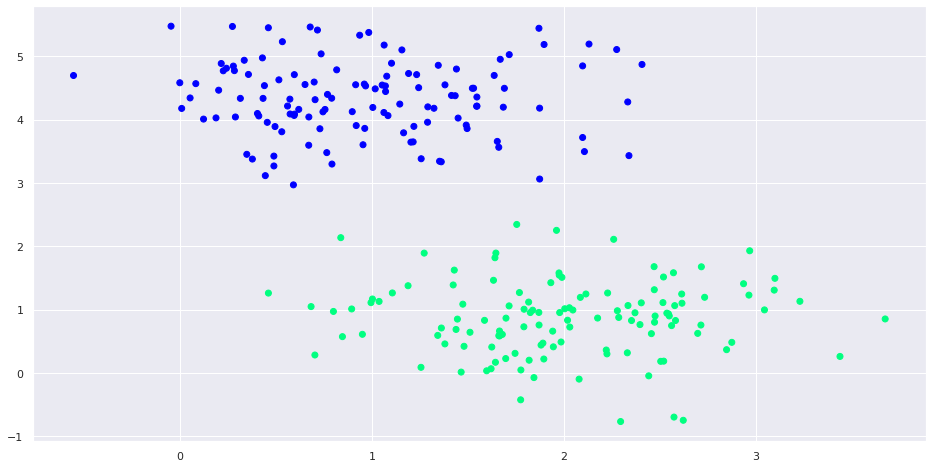

In [16]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [17]:
class LinearSVM():
    def __init__(self, C=1, gamma=1):
        self._C = C
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.dot(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        mask = a > 0.001
        self.a = a[mask]
        self.sv = X[mask]
        self.sv_y = y[mask]
        self.w = np.sum(self.a[:,None] * self.sv * self.sv_y[:,None], axis=0)
        self.b = np.dot(self.w, self.sv[0]) - self.sv_y[0]
    
    def project(self, X):
        tmp = self.a[:,None] * self.sv_y[:,None] * self.sv
        return np.sum( tmp * X[:, np.newaxis, :], axis=(1, 2)) - self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        print(xy.shape)
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  1e-15  1e-14
 6: -4.0061e+00 -4.0104e+00  4e-03  1e-15  6e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  1e-15  7e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  1e-15  6e-15
Optimal solution found.
(900, 2)


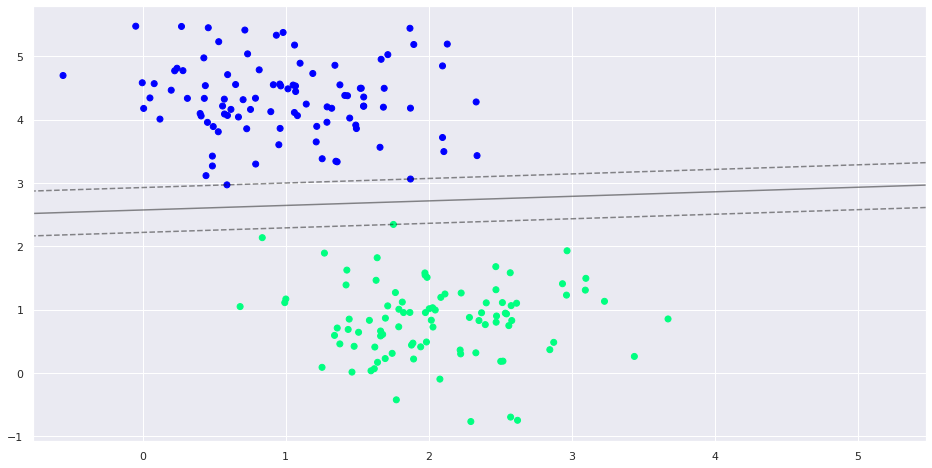

In [19]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

In [20]:
pred = svm.predict(X_test)
target = y_test

In [21]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print(classification_report(target, pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        34

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



# Нелинейный случай

In [22]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

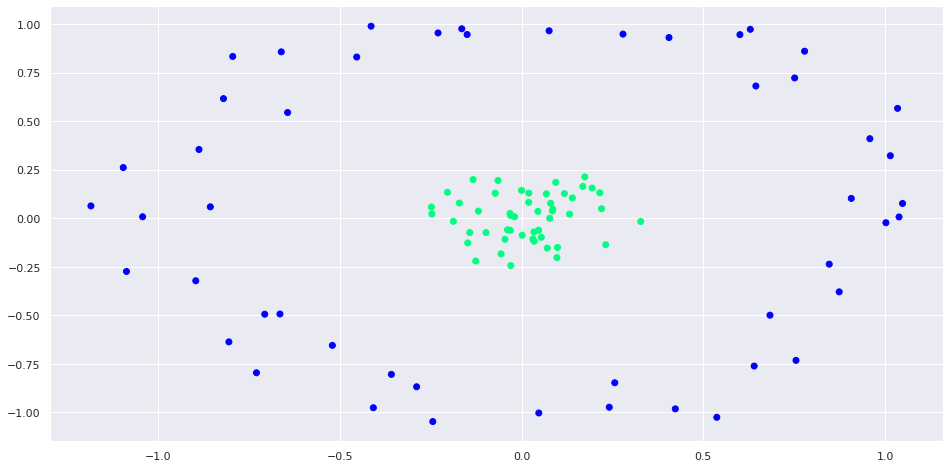

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [25]:
svm = LinearSVM(C=1)
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -7.4051e+01 -1.5605e+02  8e+01  3e-15  2e+00
 1: -1.7381e+02 -1.7835e+02  5e+00  4e-15  1e+00
 2: -6.7820e+03 -6.7875e+03  6e+00  3e-13  1e+00
 3: -8.2762e+06 -8.2762e+06  7e+01  2e-10  1e+00
 4: -2.7953e+11 -2.7953e+11  2e+06  6e-06  1e+00
Terminated (singular KKT matrix).


(900, 2)


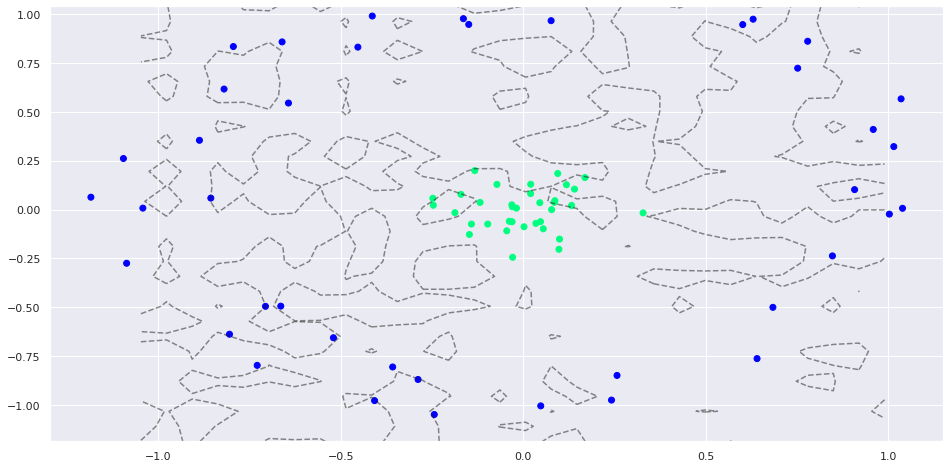

In [26]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X_train)

## Kernel SVM

In [70]:
class KernelSVM:
    def __init__(self, C=1, ker='rbf', gamma=1):
        self._C = C
        self._Ker = self.linear
        if ker=='rbf': self._Ker = self.rbf
        self._gamma = gamma
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self._Ker(X[i], X[j])
        # P = X^T X
        P = cvxopt.matrix(np.outer(y, y) * K)
        # q = -1 (1xN)
        q = cvxopt.matrix(np.ones(n_samples) * -self._C)
        # A = y^T 
        A = cvxopt.matrix(y, (1, n_samples))
        # b = 0 
        b = cvxopt.matrix(0.0)
        # -1 (NxN)
        G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        # 0 (1xN)
        h = cvxopt.matrix(np.zeros(n_samples))
    
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    
        # Множители Лагранжа
        a = np.ravel(solution['x'])
        
        mask = np.abs(a) > 0.0001
        self.a = a[mask]
#         print(a)
        self.sv = X[mask]
        self.sv_y = y[mask]
        self.w = np.sum(self.a[:,None] * self.sv * self.sv_y[:,None], axis=0)
        self.b = np.dot(self.w, self.sv[0]) - self.sv_y[0]
    
    def rbf(self, x, y):
        if len(x.shape) > 1:
            return np.exp(-np.diagonal(np.dot(x-y, (x-y).T)) * self._gamma)
        else: 
            return np.exp(-(np.dot(x-y, (x-y).T)))
        
    def linear(self, x, y):
        return np.dot(x, y.T)
    
    def project(self, X):
        sum = 0
        for n in range(len(self.a)):
            sum += self.a[n] * self.sv_y[n] * self._Ker(X, self.sv[n])
        return sum - self.b

    def predict(self, X):
        return np.sign(self.project(X))
    
    def plot(self, X):
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 30)
        y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 30)
        X_, Y_ = np.meshgrid(y, x)

        xy = np.vstack([X_.ravel(), Y_.ravel()]).T
        P = self.project(xy).reshape(X_.shape)

        # plot decision boundary and margins
        ax.contour(X_, Y_, P, colors='k',
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--']);

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [78]:
svm = KernelSVM(C=1, ker='rbf',gamma=5)
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -5.1801e+00 -1.4788e+01  1e+02  1e+01  1e+00
 1: -1.6752e+00 -1.4584e+01  1e+01  1e-15  6e-16
 2: -4.5564e+00 -7.6565e+00  3e+00  5e-16  6e-16
 3: -5.9273e+00 -6.9631e+00  1e+00  2e-15  7e-16
 4: -6.4853e+00 -6.6350e+00  1e-01  6e-16  7e-16
 5: -6.5824e+00 -6.5897e+00  7e-03  1e-15  6e-16
 6: -6.5873e+00 -6.5878e+00  5e-04  6e-16  7e-16
 7: -6.5876e+00 -6.5877e+00  1e-05  1e-15  7e-16
 8: -6.5876e+00 -6.5876e+00  2e-07  3e-15  6e-16
Optimal solution found.


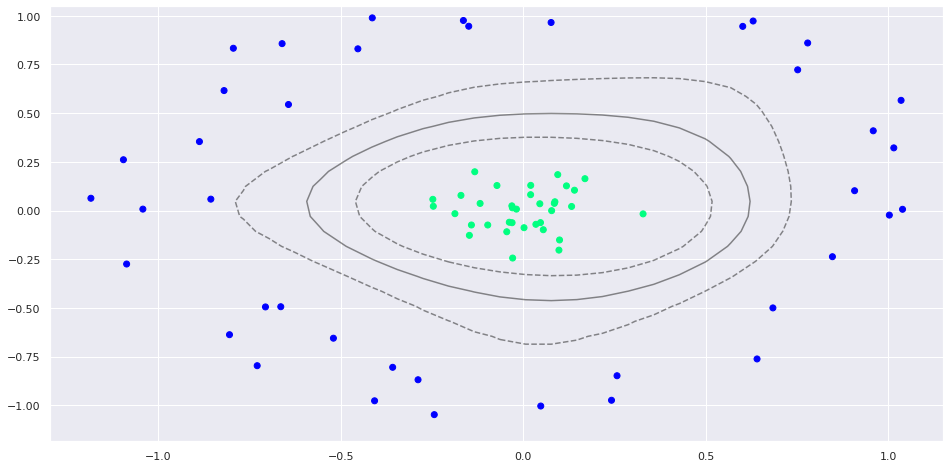

In [79]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
svm.plot(X)

In [80]:
pred = svm.predict(X_test)
target = y_test

In [81]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print(classification_report(target, pred))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



# SVM как качественный классификатор

In [82]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


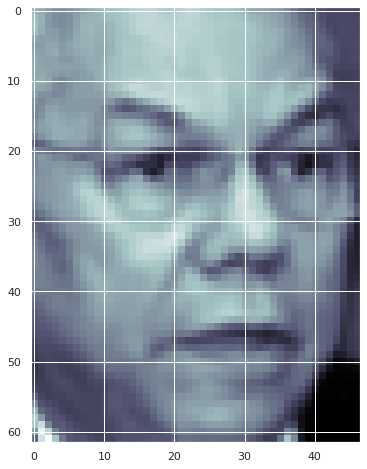

In [83]:
plt.imshow(faces.images[0], cmap='bone')

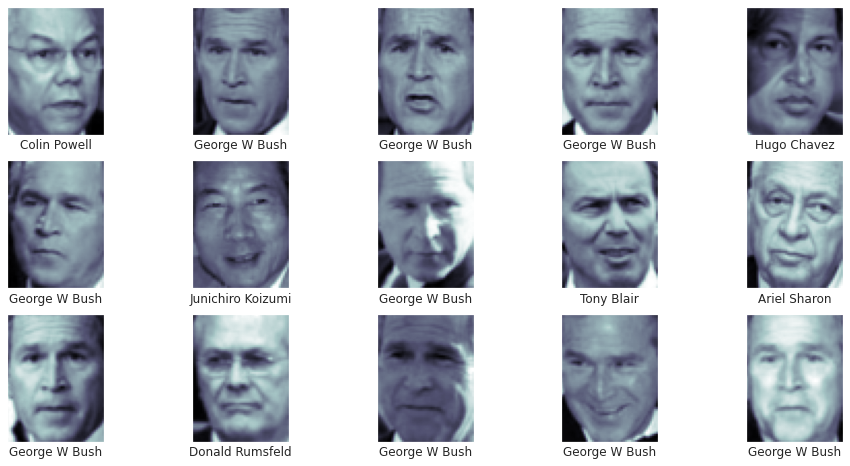

In [84]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [85]:
X = faces.data
y = faces.target

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

In [88]:
from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

SVC(C=10, class_weight='balanced', gamma=0.001)

In [89]:
pred = svm.predict(X_test)
target = y_test

In [91]:
from sklearn.metrics import precision_score, accuracy_score, classification_report

print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        31
           3       0.37      1.00      0.54       126
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        42

    accuracy                           0.37       337
   macro avg       0.05      0.12      0.07       337
weighted avg       0.14      0.37      0.20       337



In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=42)

from sklearn.svm import SVC
svm = SVC(C=10, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        31
           3       0.37      1.00      0.54       126
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        42

    accuracy                           0.37       337
   macro avg       0.05      0.12      0.07       337
weighted avg       0.14      0.37      0.20       337



# PCA

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150,whiten=True)
pca.fit(faces.data)
X = pca.transform(faces.data)

In [97]:
X.shape

(1348, 150)

In [98]:
y = faces.target

In [100]:
import random
test_frac = 0.3
num = len(X) * test_frac
ids_test = np.random.choice(range(len(X)), int(num))

In [102]:
ids_train = set(np.arange(len(X))) - set(ids_test)
ids_train = np.array(list(ids_train))
print(len(ids_train), len(ids_test))

1003 404


In [103]:
X_train = X[ids_train]
y_train = faces.target[ids_train]
X_test = X[ids_test]
y_test = faces.target[ids_test]

In [105]:
from sklearn.svm import SVC
svm = SVC(C=1, gamma=0.001, kernel='rbf', class_weight='balanced')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.71      0.65      0.68        23
           1       0.79      0.86      0.82        69
           2       0.77      0.79      0.78        43
           3       0.89      0.86      0.87       160
           4       0.74      0.79      0.77        29
           5       0.67      0.90      0.77        20
           6       1.00      0.93      0.96        14
           7       0.92      0.78      0.85        46

    accuracy                           0.83       404
   macro avg       0.81      0.82      0.81       404
weighted avg       0.84      0.83      0.83       404



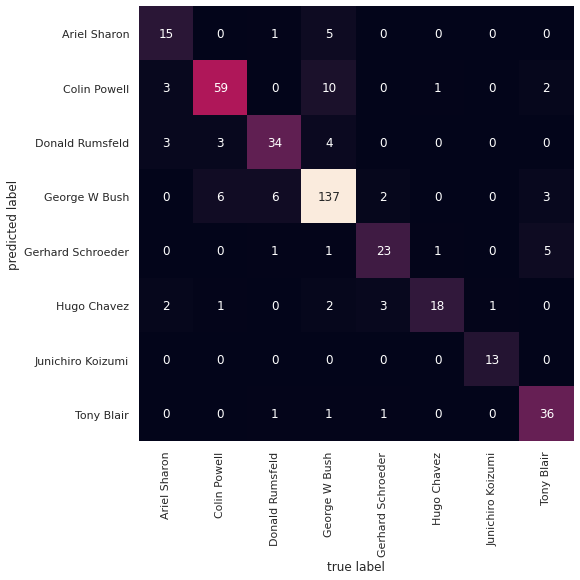

In [106]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, pred)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Draw Misclassification

In [107]:
mask = np.logical_and(pred==3, target==1)
ids_misclf = ids_test[mask]

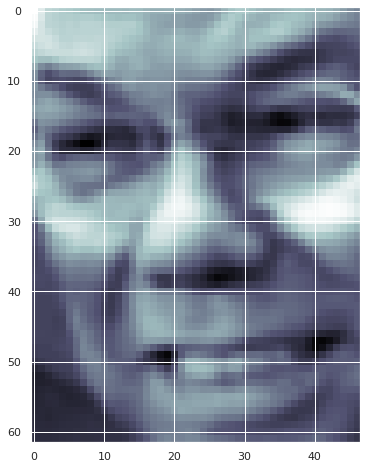

In [109]:
pic = faces.images[ids_misclf[1]]
plt.imshow(pic, cmap='bone')

## Self kernelSVM

In [110]:
y = faces.target == 1
y = np.array([1. if j else -1. for j in y])

In [111]:
X_train = X[ids_train]
y_train = y[ids_train]
X_test = X[ids_test]
y_test = y[ids_test]

In [113]:
svm = KernelSVM(C=10, gamma=0.001, ker='rbf')
svm.fit(X_train,y_train)

pred = svm.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print(classification_report(target, pred))

     pcost       dcost       gap    pres   dres
 0: -2.2251e+04 -3.4697e+04  1e+04  5e-13  9e-01
 1: -2.9486e+04 -2.9716e+04  2e+02  1e-12  8e-02
 2: -2.9667e+04 -2.9670e+04  2e+00  3e-12  3e-04
 3: -2.9667e+04 -2.9667e+04  2e-02  3e-13  3e-06
 4: -2.9667e+04 -2.9667e+04  2e-04  2e-13  3e-08
Optimal solution found.
              precision    recall  f1-score   support

        -1.0       0.83      1.00      0.91       335
         1.0       0.00      0.00      0.00        69

    accuracy                           0.83       404
   macro avg       0.41      0.50      0.45       404
weighted avg       0.69      0.83      0.75       404



# Cross Validation

In [114]:
y = faces.target

In [116]:
X_train, y_train = None, None
X_test, y_test = None, None
X_val, y_val = None, None

In [117]:
import itertools

best_model = None
best_f1 = 0
best_params = None

grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}

for c,gamma in itertools.product(grid['C'], grid['gamma']):
    pass

In [119]:
best_params

In [ ]:
pred = best_model.predict(X_test)
target = y_test

from sklearn.metrics import precision_score, accuracy_score, classification_report
print classification_report(target, pred)